# CNN Classifier

the CNN implementation after improvement applied

In [17]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes=15):
        super(CNN, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(8)

        # Conv Block 2
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
        self.bn2   = nn.BatchNorm2d(16)

        # Conv Block 3
        self.conv3 = nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=3)
        self.bn3   = nn.BatchNorm2d(32)

        # Conv Block 4
        self.conv4 = nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3)
        self.bn4   = nn.BatchNorm2d(32)

        # Conv Block 5
        self.conv5 = nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=3)
        self.bn5   = nn.BatchNorm2d(32)

        # Dropouts
        self.drop_conv = nn.Dropout2d(p=0.05)   # light dropout after conv blocks
        self.drop_fc   = nn.Dropout(p=0.1)     # strong dropout before FC

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)

        # 64→32→16 spatial resolution
        self.fc = nn.Linear(32 * 16 * 16, num_classes)


    def forward(self, x):

        # BLOCK 1
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)              # pool only on first two blocks
        x = self.drop_conv(x)

        # BLOCK 2
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.drop_conv(x)

        # BLOCK 3
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.drop_conv(x)

        # BLOCK 4
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.drop_conv(x)

        # BLOCK 5
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.drop_conv(x)

        # FC
        x = x.view(x.size(0), -1)
        x = self.drop_fc(x)           # strong dropout before classification
        x = self.fc(x)

        return x


# Training helper
def train_one_epoch(model, loader, criterion, optimizer, device):

    model.train()
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in loader:
    
        inputs, targets = inputs.to(device), targets.to(device)
    
        optimizer.zero_grad() # Zero the parameter gradients
    
        outputs = model(inputs) # Forward pass
    
        loss = criterion(outputs, targets) # Compute loss
    
        loss.backward() # Backward pass
    
        optimizer.step() # Optimize weights

        total_loss += loss.item() * inputs.size(0) # Accumulate loss
        
        _, preds = outputs.max(1) # Get predictions
        
        correct += preds.eq(targets).sum().item() # Count correct predictions
        
        total += targets.size(0) # Count total samples
    
    return total_loss / total, correct / total # Return average loss and accuracy

# Evaluation helper
def evaluate(model, loader, criterion, device):

    model.eval() # Set model to evaluation mode
    
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
    
        for inputs, targets in loader:
    
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
            
    return total_loss / total, correct / total


In [19]:
# Set the path to your dataset and parameters
data_root = Path('/Users/leonardoangellotti/Desktop/universita/Comp_Vision/CNN/data_augmented')
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define class names
class_names = ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity',
               'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry',
               'Store', 'Street', 'Suburb', 'TallBuilding']

# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load datasets
train_dir = data_root / 'train'
val_dir = data_root / 'val'
test_dir = data_root / 'test'

train_dataset = datasets.ImageFolder(str(train_dir), transform=transform)

if val_dir.exists():
    val_dataset = datasets.ImageFolder(str(val_dir), transform=transform)
else:
    total_train = len(train_dataset)
    val_size = int(0.15 * total_train)
    train_size = total_train - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size],
                                            generator=torch.Generator().manual_seed(42))

test_dataset = datasets.ImageFolder(str(test_dir), transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

Using device: cpu


In [20]:
# Number of training samples
print("Number of training images:", len(train_dataset))

# Inspect one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)
print("Batch label tensor shape:", labels.shape)

# Inspect one image
print("Single image shape:", images[0].shape)


Number of training images: 5100
Batch image tensor shape: torch.Size([32, 1, 64, 64])
Batch label tensor shape: torch.Size([32])
Single image shape: torch.Size([1, 64, 64])


In [21]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def plot_sample_images_per_class_2rows(train_loader, class_names):

    num_classes = len(class_names)
    sample_images = [None] * num_classes

    # Collect one sample per class
    for images, labels in train_loader:
        images = images.cpu()
        labels = labels.cpu()

        for img, lab in zip(images, labels):
            lab = int(lab.item())
            if sample_images[lab] is None:
                sample_images[lab] = img

        if all(img is not None for img in sample_images):
            break

    # Layout: two rows → first row 8 images, second row 7 images
    rows = 2
    cols_row1 = 8
    cols_row2 = num_classes - cols_row1  # = 7

    fig, axes = plt.subplots(rows, cols_row1, figsize=(cols_row1 * 2, 4))

    # Flatten axes for easier indexing, but note last row only uses 7 columns
    axes = axes.reshape(rows, cols_row1)

    # Plot first row (0–7)
    for i in range(cols_row1):
        img = ToPILImage()(sample_images[i].squeeze(0))
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(class_names[i], fontsize=8)
        axes[0, i].axis('off')

    # Plot second row (8–14)
    for j in range(cols_row2):
        img = ToPILImage()(sample_images[cols_row1 + j].squeeze(0))
        axes[1, j].imshow(img, cmap='gray')
        axes[1, j].set_title(class_names[cols_row1 + j], fontsize=8)
        axes[1, j].axis('off')

    # Hide unused axes (only needed for last column of row 2)
    for k in range(cols_row2, cols_row1):
        axes[1, k].axis('off')

    plt.tight_layout()
    plt.show()


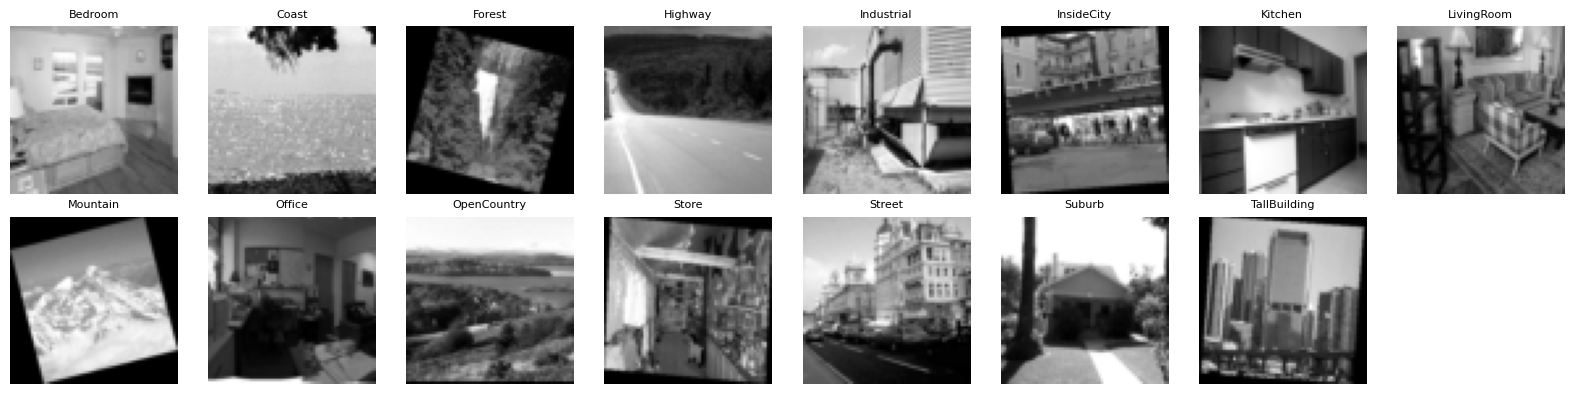

In [22]:
plot_sample_images_per_class_2rows(train_loader, class_names)

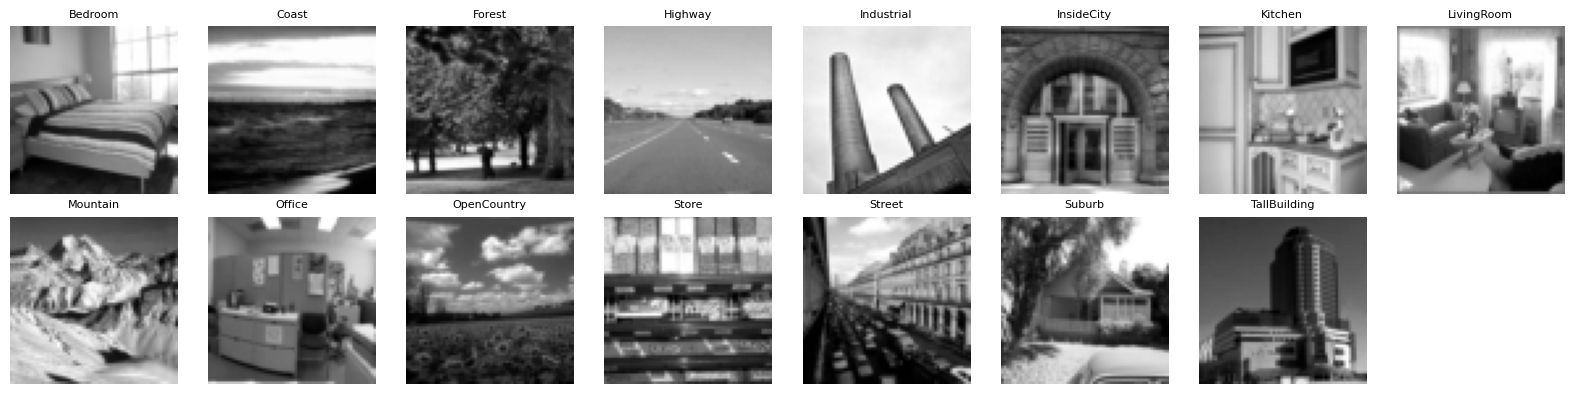

In [23]:
plot_sample_images_per_class_2rows(val_loader, class_names)

In [24]:
num_epochs = 12
learning_rate = 0.01
momentum = 0.9

Epoch 1/12 - train_loss: 4.3871, train_acc: 0.1375, val_loss: 2.3011, val_acc: 0.3067
Epoch 2/12 - train_loss: 2.2830, train_acc: 0.2653, val_loss: 2.2455, val_acc: 0.3067
Epoch 3/12 - train_loss: 2.0909, train_acc: 0.3375, val_loss: 1.7731, val_acc: 0.4489
Epoch 4/12 - train_loss: 1.8374, train_acc: 0.4173, val_loss: 1.7318, val_acc: 0.4622
Epoch 5/12 - train_loss: 1.6677, train_acc: 0.4625, val_loss: 1.6378, val_acc: 0.4400
Epoch 6/12 - train_loss: 1.4980, train_acc: 0.5124, val_loss: 1.6522, val_acc: 0.4978
Epoch 7/12 - train_loss: 1.3537, train_acc: 0.5616, val_loss: 1.6254, val_acc: 0.4756
Epoch 8/12 - train_loss: 1.2385, train_acc: 0.6055, val_loss: 1.5836, val_acc: 0.5422
Epoch 9/12 - train_loss: 1.1220, train_acc: 0.6351, val_loss: 1.6912, val_acc: 0.4889
Epoch 10/12 - train_loss: 0.9824, train_acc: 0.6737, val_loss: 1.7820, val_acc: 0.4844
Epoch 11/12 - train_loss: 0.9227, train_acc: 0.6976, val_loss: 1.9541, val_acc: 0.4178
Epoch 12/12 - train_loss: 0.8067, train_acc: 0.7322,

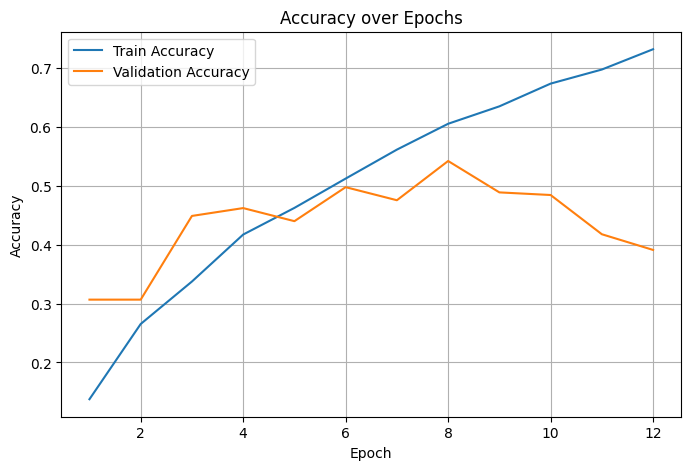

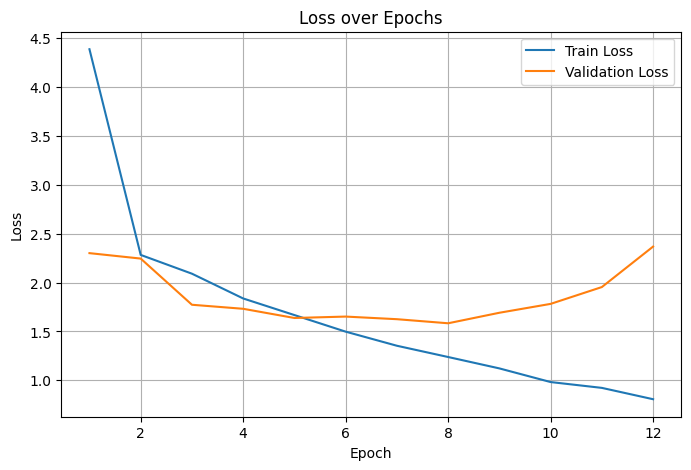

In [25]:
# Create model, criterion, optimizer
model = CNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             betas=(0.9, 0.999),
                             weight_decay=0)

# Training loop with early stopping
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')
patience, patience_counter = 10, 0

for epoch in range(1, num_epochs + 1):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f'Epoch {epoch}/{num_epochs} - train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

# Load best model and plot training curves
model.load_state_dict(torch.load('best_model.pth', map_location=device))
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accs, label='Train Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy over Epochs'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss over Epochs'); plt.legend(); plt.grid(True); plt.show()


Test Accuracy: 46.70%


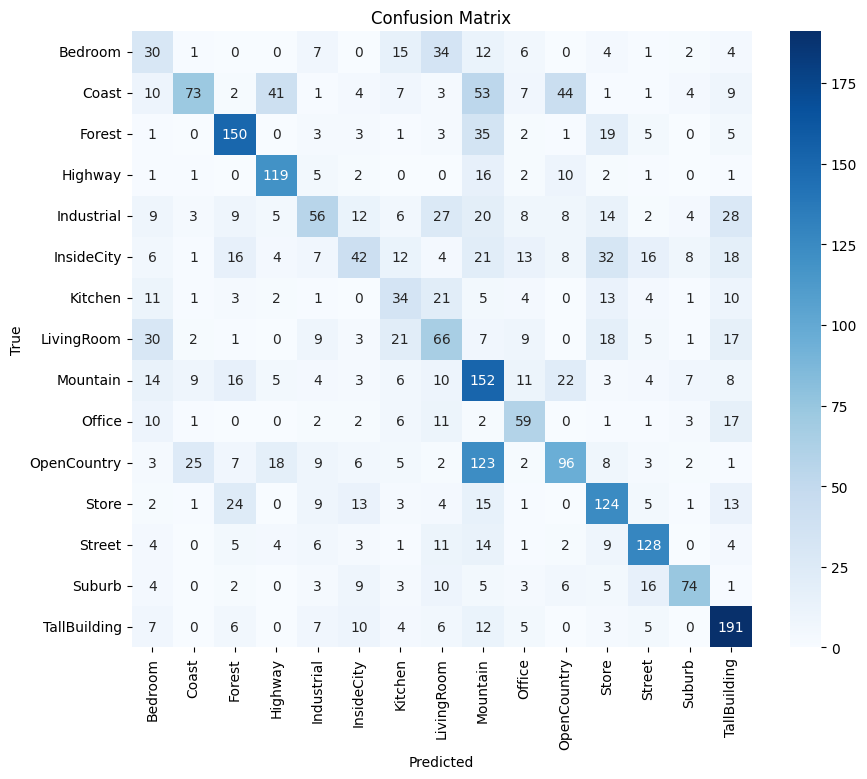

In [26]:
# Evaluate on the test set and display confusion matrix
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():

    for inputs, targets in test_loader:

        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f'Test Accuracy: {test_acc * 100:.2f}%')

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix'); plt.show()